In [341]:
%matplotlib inline
import numpy as np
import os
import pathlib
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import keras_applications, keras_preprocessing
import re
import cv2
import matplotlib.patches as patches
from sklearn import preprocessing
from matplotlib.image import imread
from tqdm import tqdm
import shutil
import seaborn as sns

### check how .csv data look like

In [349]:
data_path = os.path.join('I:/Kaggle/Global Wheat Detection',  'train' + '.' + 'csv')
df_train = pd.DataFrame(pd.read_csv(data_path))
print(df_train.shape)
df_train.head()

(147793, 5)


image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

# Data preparation and preprocessing

### writing class to load and plot images
#### visualizing data and bounding boxes

In [316]:
class plot_bbox:
    def __init__(self, image_dir, annot_path, image_num, suffix_, df_sample):
        self.image_dir = image_dir
        self.annot_path = annot_path
        self.image_num = image_num
        self.suffix_ = suffix_
        self.df_sample = df_sample
        
    def load_images(self):
        dir_list = os.listdir(self.image_dir)
        pur_image_names = []
        [pur_image_names.append(img) for img in dir_list if img.endswith('.' + self.suffix_)]
        
        print('%d images are selected at random' % self.image_num)
        
        selected_image_names = np.random.choice(pur_image_names, size = self.image_num)
        
        # start loading images and locate them is 4D array
        images_array = []
        images_array = [imread(os.path.join(self.image_dir, name)) for name in selected_image_names]
        
        
        return images_array, selected_image_names
    
    def load_annotations(self):
        
        if self.df_sample:
            df_temp = pd.read_csv(self.annot_path)
            df_ = pd.DataFrame(columns=df_temp.columns)
            for i, names in enumerate(list(set(df_temp.source.values))):
                df_ = df_.append(df_temp[df_temp.source == names].sample(n = self.df_sample))
        else:
            df_ = pd.read_csv(self.annot_path)
        return df_
    
    def plot_(self):
        
        images_, image_names = self.load_images()
        
        df_annot = self.load_annotations()
        
        nr_ = self.image_num
        
        # creating plot
        subplot_row = int(np.ceil(nr_/4))
        subplot_col = 4
        f, axes = plt.subplots(subplot_row, subplot_col, figsize= (14, 3 * subplot_row))
        
        
        for i, ax in enumerate(axes.flat):
            try:
                ax.imshow(np.uint8(images_[i]), vmin = 0, vmax = 255, interpolation='nearest')
                ax.set_axis_off()
                ax.set_title(image_names[i])
                # add bbox per image
                # search for all bboxes per image name
                
                boxes = df_annot[df_annot.image_id == image_names[i][:-4]].bbox.values
                
                if 1:
                    for ind in range(boxes.shape[0]):
                        temp_box = re.findall('[0-9.]+', boxes[ind])
                        ax.add_patch(patches.Rectangle((float(temp_box[0]),float(temp_box[1])),
                                                       float(temp_box[2]),float(temp_box[3]),
                                                      linewidth = 1, edgecolor = 'r', 
                                                       facecolor = 'none'))
                
            except:
                ax.set_axis_off()
                print('number of axes are more than images')
            
        plt.show()
        
        
    def plot_given_input(self, input_images, input_image_names, nr_):
        
        images_ = input_images
        image_names = input_image_names
        
        df_annot = self.load_annotations()
        
        
        # creating plot
        subplot_row = int(np.ceil(nr_/4))
        subplot_col = 4
        f, axes = plt.subplots(subplot_row, subplot_col, figsize= (14, 3 * subplot_row))
        
        
        for i, ax in enumerate(axes.flat):
            try:
                ax.imshow(images_[i], vmin = 0, vmax = 255)
                ax.set_axis_off()
                ax.set_title(image_names[i])
                # add bbox per image
                # search for all bboxes per image name
                
                boxes = df_annot[df_annot.image_id == image_names[i][:-4]].bbox.values
                
                if 1:
                    for ind in range(boxes.shape[0]):
                        temp_box = re.findall('[0-9.]+', boxes[ind])
                        ax.add_patch(patches.Rectangle((float(temp_box[0]),float(temp_box[1])),
                                                       float(temp_box[2]),float(temp_box[3]),
                                                      linewidth = 1, edgecolor = 'r', 
                                                       facecolor = 'none'))
                
            except:
                ax.set_axis_off()
                print('number of axes are more than images')
            
        plt.show()
        
    def create_yolo_style1(self):
        image_dir_parent = str(pathlib.Path(self.image_dir).parent)
        print('creating new folder with name style1')
        if not os.path.isdir(os.path.join(image_dir_parent, 'style1')):
            os.makedirs(os.path.join(image_dir_parent, 'style1'))
        else:
            print('the folder was already created')
        save_path = os.path.join(image_dir_parent, 'style1')
        
        dir_list = os.listdir(self.image_dir)
        pur_image_names = []
        [pur_image_names.append(img) for img in dir_list if img.endswith('.' + self.suffix_)]
        
        # now take csv file and clean and save it as txt file
        df_ =  self.load_annotations()
        # make df_ more conviniet for later
        # initialize with 0
        df_ = df_.assign(**{'x': 0, 'y': 0, 'width_': 0, 'height_': 0,
                           'x_norm': 0, 'y_norm': 0, 'width_norm': 0, 'height_norm': 0})
        bbox_ = []
        [bbox_.append(list(map(float,re.findall('\d+(?:\.\d+)?', box)))) for box in df_.bbox]
        df_[['x', 'y', 'width_', 'height_']] = pd.DataFrame(bbox_)
        
        list_ = list((df_.x.values / df_.width.values, df_.y.values / df_.height.values, df_.width_.values / df_.width.values, df_.height_.values / df_.height.values))
        list_ = list(map(list, zip(*list_)))
        df_[['x_norm', 'y_norm', 'width_norm', 'height_norm']] = pd.DataFrame(list_)
        
        #import pdb;pdb.set_trace()
        
        # now for each unique image name I have to create 1 .txt file
        # then start with finding unique names
        df_all_names = df_.image_id
        unique_names = list(set(df_all_names))
        print('it is creating text file, it could take a moment ...')
        [df_[df_.image_id == name].drop(['image_id', 'source', 'bbox', 'x', 'y', 'width_', 'height_'], axis = 1).assign(labels = 0).reindex(columns = ['labels', 'x_norm', 'y_norm', 'width_norm', 'height_norm']).to_csv(os.path.join(save_path, name + '.txt'), header=False, sep= ' ', index=False) for name in unique_names]
        print('start copying images, be patient ...')
        [shutil.copy(os.path.join(self.image_dir, name + '.' + self.suffix_), save_path) for name in unique_names]
        print('check files in ', save_path)
        
        
    def create_yolo_style2(self):
        image_dir_parent = str(pathlib.Path(self.image_dir).parent)
        print('creating new folder with name style2')
        if not os.path.isdir(os.path.join(image_dir_parent, 'style2')):
            os.makedirs(os.path.join(image_dir_parent, 'style2'))
        else:
            print('the folder was already created')
        save_path = os.path.join(image_dir_parent, 'style2')
        
        dir_list = os.listdir(self.image_dir)
        pur_image_names = []
        [pur_image_names.append(img) for img in dir_list if img.endswith('.' + self.suffix_)]
        
        # now take csv file and clean and save it as txt file
        df_ =  self.load_annotations()
        # make df_ more conviniet for later
        # initialize with 0
        df_ = df_.assign(**{'x': 0, 'y': 0, 'width_': 0, 'height_': 0,
                           'x_norm': 0, 'y_norm': 0, 'width_norm': 0, 'height_norm': 0})
        bbox_ = []
        [bbox_.append(list(map(float,re.findall('\d+(?:\.\d+)?', box)))) for box in df_.bbox]
        df_[['x', 'y', 'width_', 'height_']] = pd.DataFrame(bbox_)
        
        list_ = list((df_.x.values / df_.width.values, df_.y.values / df_.height.values, df_.width_.values / df_.width.values, df_.height_.values / df_.height.values))
        list_ = list(map(list, zip(*list_)))
        df_[['x_norm', 'y_norm', 'width_norm', 'height_norm']] = pd.DataFrame(list_)
        
        
        
        # now for each unique image name I have to create 1 .txt file
        # then start with finding unique names
        df_all_names = df_.image_id
        unique_names = list(set(df_all_names))
        print('it is creating text file, it could take a moment ...')
        [df_[df_.image_id == name].drop(['image_id', 'source', 'bbox', 'x', 'y', 'width_', 'height_'], axis = 1).assign(labels = 0).reindex(columns = ['labels', 'x_norm', 'y_norm', 'width_norm', 'height_norm']).to_csv(os.path.join(save_path, name + '.txt'), header=False, sep= ' ', index=False) for name in unique_names]
        print('start copying images, be patient ...')
        [shutil.copy(os.path.join(self.image_dir, name + '.' + self.suffix_), save_path) for name in unique_names]
        
        #remained images
        print('creating txt files and copying images for remained images ...')
        remained_images = [image[:-4] for image in pur_image_names if image[:-4] not in unique_names]
        print('size of images without bbox: ', len(remained_images))
        print('size of images with bbox: ', len(unique_names))
        print('data is heavily imbalanced !!!')
        [shutil.copy(os.path.join(self.image_dir, name + '.' + self.suffix_), save_path) for name in remained_images]
        class__ = 1
        [np.savetxt(os.path.join(save_path, name + '.txt'), np.append(class__, np.zeros((1,4))), newline= ' ') for name in remained_images]
        print('check files in ', save_path)
        

### first visualization

16 images are selected at random


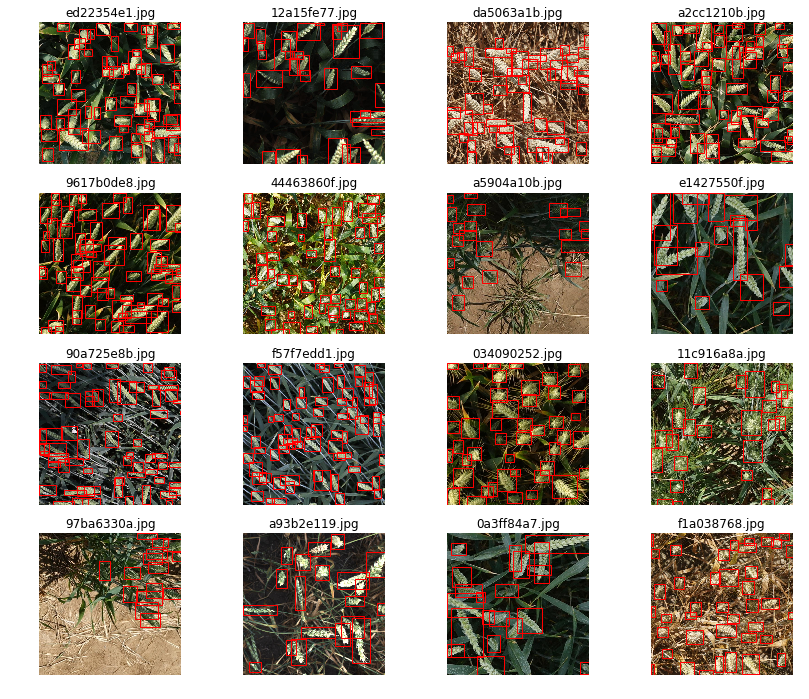

In [85]:

P = plot_bbox(image_dir='I:/Kaggle/Global Wheat Detection/train',
             image_num=16,
             annot_path='I:/Kaggle/Global Wheat Detection/train.csv',
            suffix_='jpg')
P.plot_()

## Normalization step

In [322]:
# first read all data from image folder
P = plot_bbox(image_dir='I:/Kaggle/Global Wheat Detection/train',
             image_num=50,
             annot_path='I:/Kaggle/Global Wheat Detection/train.csv',
            suffix_='jpg')
all_images, all_names = P.load_images()
len(all_images)
all_images_array = np.array(all_images)
print(all_images_array.shape)

50 images are selected at random
(50, 1024, 1024, 3)


In [339]:
def per_channel_norm(input_data, standard_,  rgb, hist_equal, ada_hist_equal):
    
    n, x, y, ch = input_data.shape
    
    # initialize
    input_data_norm = np.zeros_like(input_data)
    
    # first split channels
    r_channel = np.int32(input_data[:,:,:,0].reshape(-1,x*y))
    g_channel = np.int32(input_data[:,:,:,1].reshape(-1,x*y))
    b_channel = np.int32(input_data[:,:,:,2].reshape(-1,x*y))
    
    if standard_:
    
        r_channel = preprocessing.StandardScaler().fit_transform(r_channel)
        g_channel = preprocessing.StandardScaler().fit_transform(g_channel)
        b_channel = preprocessing.StandardScaler().fit_transform(b_channel)
        
        
        r_channel = preprocessing.MinMaxScaler().fit_transform(r_channel) * 255
        g_channel = preprocessing.MinMaxScaler().fit_transform(g_channel) * 255
        b_channel = preprocessing.MinMaxScaler().fit_transform(b_channel) * 255
        
    if rgb:
        imageMagnitude = np.sqrt(r_channel**2 + g_channel**2 + b_channel**2)
        r_channel = (r_channel / imageMagnitude) * 255
        g_channel = (g_channel / imageMagnitude) * 255
        b_channel = (b_channel / imageMagnitude) * 255
    
    input_data_norm[:,:,:,0] = np.uint8(r_channel.reshape(-1,x,y))
    input_data_norm[:,:,:,1] = np.uint8(g_channel.reshape(-1,x,y))
    input_data_norm[:,:,:,2] = np.uint8(b_channel.reshape(-1,x,y))
    
    if hist_equal:
        from cv2 import equalizeHist
        for i in range(input_data_norm.shape[0]):
            for ii in range(3):
                input_data_norm[i,:,:,ii] = equalizeHist(input_data_norm[i,:,:,ii])
        
    if ada_hist_equal:
        from cv2 import createCLAHE
        clahe = createCLAHE(clipLimit=1.6, tileGridSize=(16,16))
        for i in range(input_data_norm.shape[0]):
            for ii in range(3):
                input_data_norm[i,:,:,ii] = clahe.apply(input_data_norm[i,:,:,ii])
    
    
    return input_data_norm
    

In [334]:
help(cv2.createCLAHE)

Help on built-in function createCLAHE:

createCLAHE(...)
    createCLAHE([, clipLimit[, tileGridSize]]) -> retval
    .   @brief Creates a smart pointer to a cv::CLAHE class and initializes it.
    .   
    .   @param clipLimit Threshold for contrast limiting.
    .   @param tileGridSize Size of grid for histogram equalization. Input image will be divided into
    .   equally sized rectangular tiles. tileGridSize defines the number of tiles in row and column.



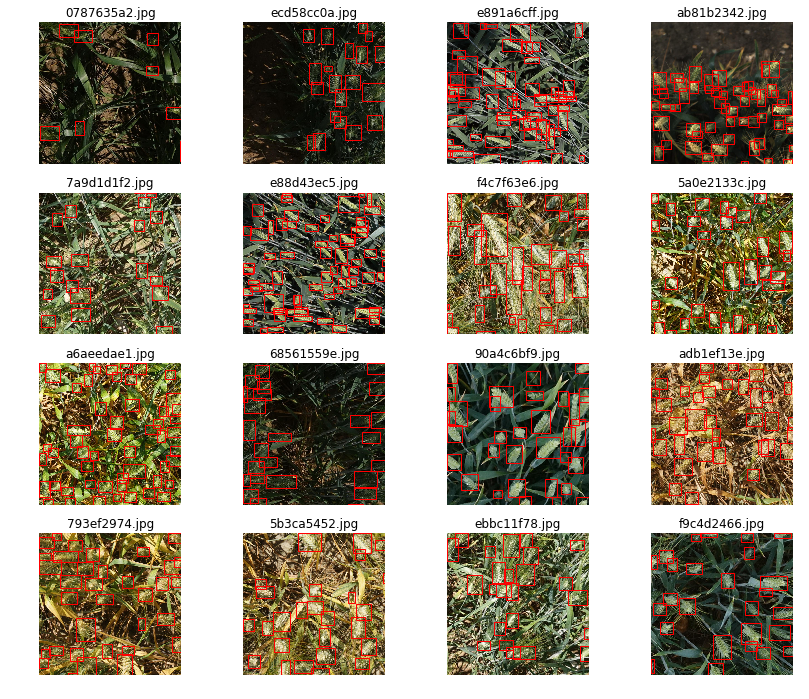

In [332]:
norm_images_ = per_channel_norm(all_images_array, False,  False, False, False)
P.plot_given_input(input_images=norm_images_[0:16], input_image_names=all_names[0:16], nr_=16)

### trying different normalization

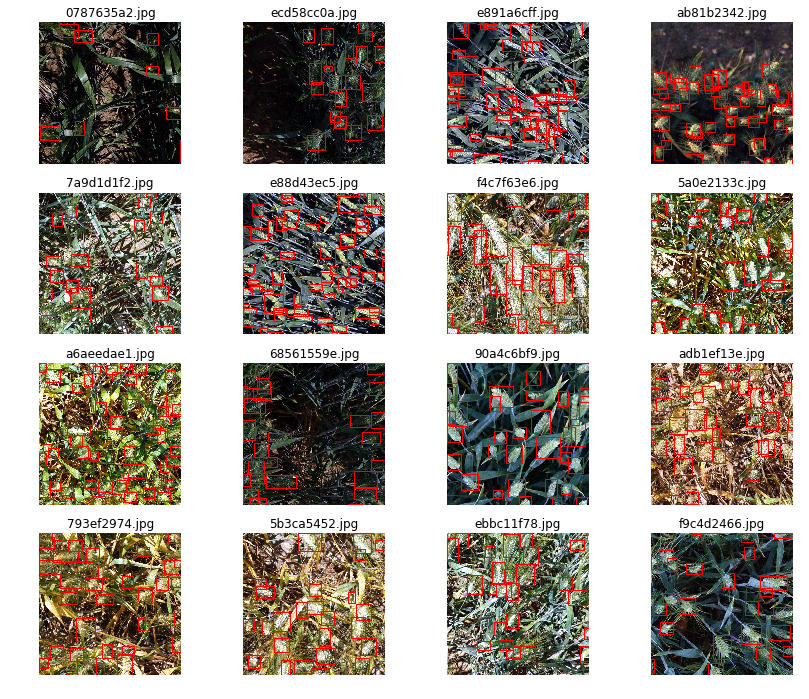

In [331]:
# normalizing data then scaling to between 0-1
norm_images = per_channel_norm(all_images_array, True,  False, False, False)
P.plot_given_input(input_images=norm_images[0:16], input_image_names=all_names[0:16], nr_=16)

c:\users\admin\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
c:\users\admin\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
c:\users\admin\anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


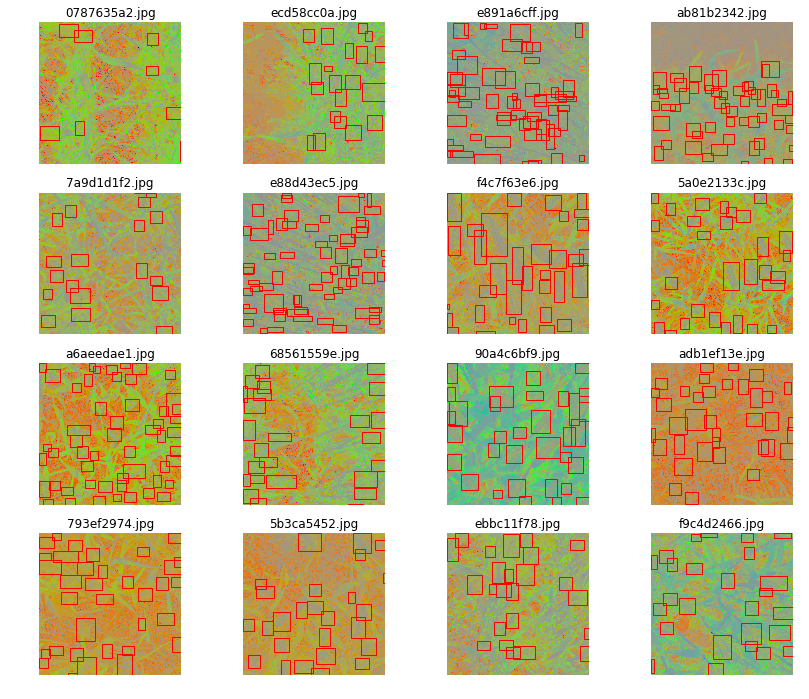

In [330]:
norm_images_rgb = per_channel_norm(all_images_array, False,  True, False, False)
P.plot_given_input(input_images=norm_images_rgb[0:16], input_image_names=all_names[0:16], nr_=16)

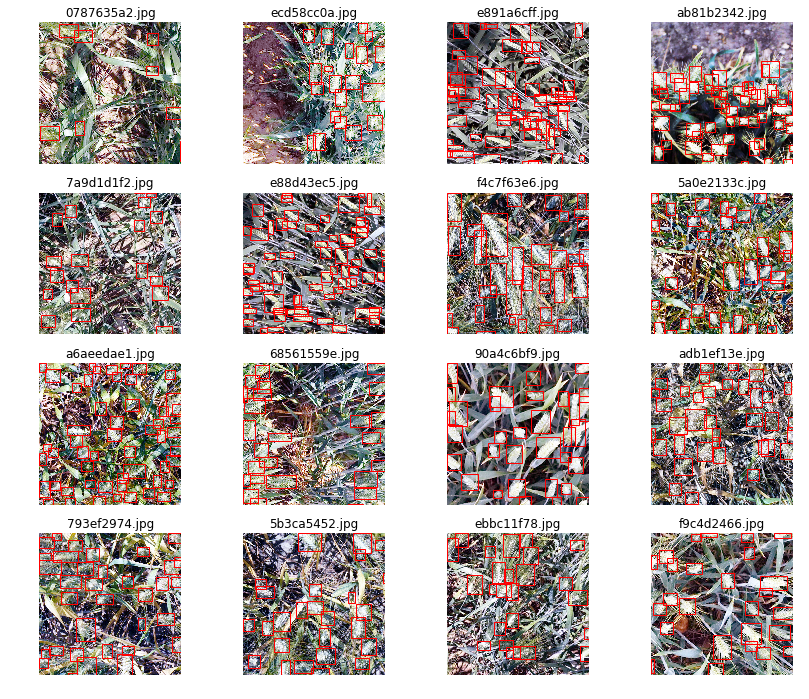

In [328]:
norm_images_rgb = per_channel_norm(all_images_array, False,  False, True, False)
P.plot_given_input(input_images=norm_images_rgb[0:16], input_image_names=all_names[0:16], nr_=16)

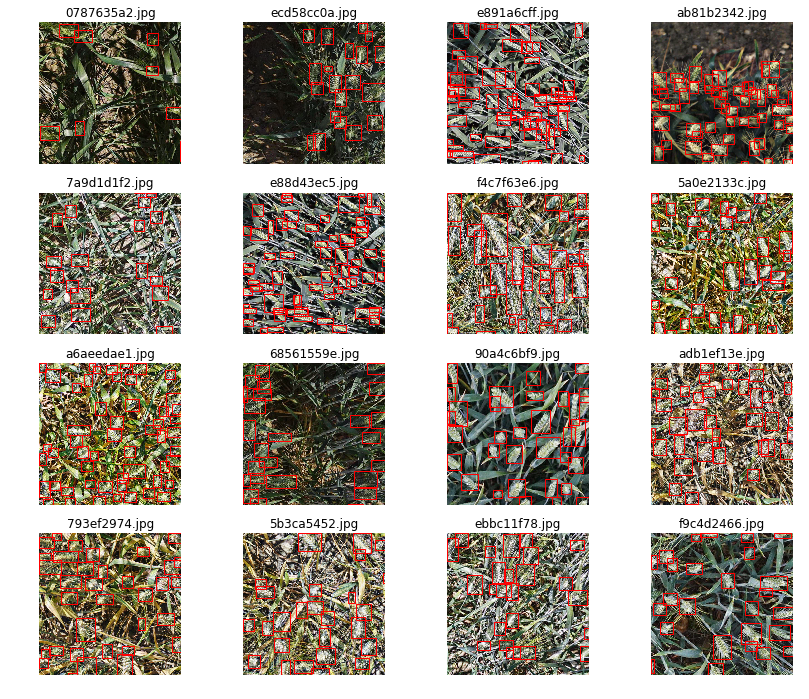

In [340]:
norm_images_rgb = per_channel_norm(all_images_array, False,  False, False, True)
P.plot_given_input(input_images=norm_images_rgb[0:16], input_image_names=all_names[0:16], nr_=16)

## Preparing Yolo annotation

From Kaggle page:  
What am I predicting?   
You are attempting to predict bounding boxes around each wheat head in images that have them. If there are no wheat heads, you must predict no bounding boxes.

In [287]:
# Style 1
#   - when we have only 1 class and images without objects can be 
#     detected by thresholding detection probability

P = plot_bbox(image_dir='I:/Kaggle/Global Wheat Detection/train',
             image_num=[],
             annot_path='I:/Kaggle/Global Wheat Detection/train.csv',
            suffix_='jpg')
P.create_yolo_style1()

creating new folder with name style1
it is creating text file, it could take a moment ...
start copying images, be patient ...
check files in  I:\Kaggle\Global Wheat Detection\style1


In [317]:
# Style 2
#   - when we have two classes (with object and without object)
#        - The problem is for two classes detection we have strongly imbalanced dataset
#            - we can use data augmentation


P = plot_bbox(image_dir='I:/Kaggle/Global Wheat Detection/train',
             image_num=[],
             annot_path='I:/Kaggle/Global Wheat Detection/train.csv',
            suffix_='jpg')
P.create_yolo_style2()

creating new folder with name style2
the folder was already created
it is creating text file, it could take a moment ...
start copying images, be patient ...
creating txt files and copying images for remained images ...
size of images without bbox:  49
size of images with bbox:  3373
data is heavily imbalanced !!!
check files in  I:\Kaggle\Global Wheat Detection\style2


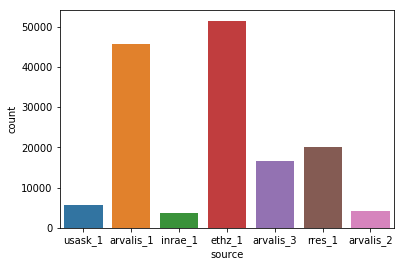

In [345]:
# considering each source as a class label
sns.countplot(x='source', data = df_train)
print(df_train.source)

In [363]:
df_train.groupby('source').count()

image_id  width  height   bbox
source                                   
arvalis_1     45716  45716   45716  45716
arvalis_2      4179   4179    4179   4179
arvalis_3     16665  16665   16665  16665
ethz_1        51489  51489   51489  51489
inrae_1        3701   3701    3701   3701
rres_1        20236  20236   20236  20236
usask_1        5807   5807    5807   5807

In [393]:
df2 = pd.DataFrame(columns=df_train.columns)
for i, names in enumerate(list(set(df_train.source.values))):
    df2 = df2.append(df_train[df_train.source == names].sample(n = 2))

In [394]:
df2

image_id width height                          bbox     source
28303   f931c0224  1024   1024   [905.0, 474.0, 119.0, 81.0]  arvalis_1
39921   625c80346  1024   1024              [878, 0, 81, 22]  arvalis_1
142830  7e6a307fd  1024   1024    [469.0, 77.0, 103.0, 67.0]     rres_1
136021  eab32c67a  1024   1024    [336.0, 274.0, 58.0, 59.0]     rres_1
144236  d17efcdba  1024   1024    [181.0, 189.0, 37.0, 56.0]  arvalis_2
147543  893938464  1024   1024       [0.0, 289.0, 2.0, 84.0]  arvalis_2
53802   f5e3315ab  1024   1024  [760.0, 327.0, 123.0, 105.0]    inrae_1
51627   5a3e0c6b5  1024   1024  [667.0, 511.0, 109.0, 113.0]    inrae_1
5152    91a285076  1024   1024  [663.0, 144.0, 103.0, 116.0]    usask_1
5510    ed23785c8  1024   1024   [121.0, 390.0, 85.0, 110.0]    usask_1
109251  b0caf416d  1024   1024    [824.0, 69.0, 87.0, 115.0]  arvalis_3
118645  3abd6b428  1024   1024   [455.0, 565.0, 77.0, 110.0]  arvalis_3
57944   c3e712a5d  1024   1024   [910.0, 720.0, 114.0, 76.0]     ethz_1
106108  04fe56fd3  1024   1024    [542.0, 962.0, 51.0, 62.0]     ethz_1